In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.tree import plot_tree
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Walmart.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [3]:
df.loc[df['Weekly_Sales']<=0]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


(-321.70000000000005, 6755.7)

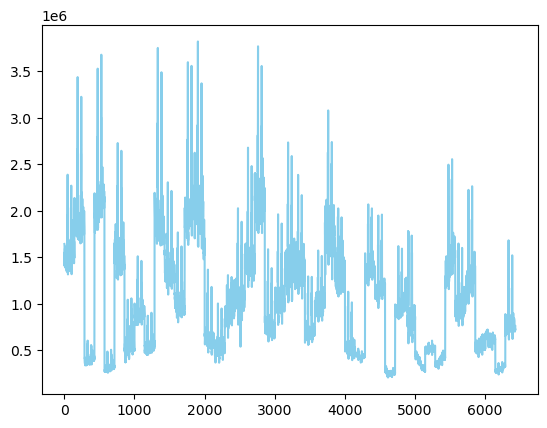

In [4]:
plt.plot(df['Weekly_Sales'], color="skyblue")
plt.xlim()

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
df['Semana_del_Año'] = df['Date'].dt.isocalendar().week
df


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Semana_del_Año
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9
...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,9,2012,39
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,10,2012,40
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,10,2012,41
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,10,2012,42


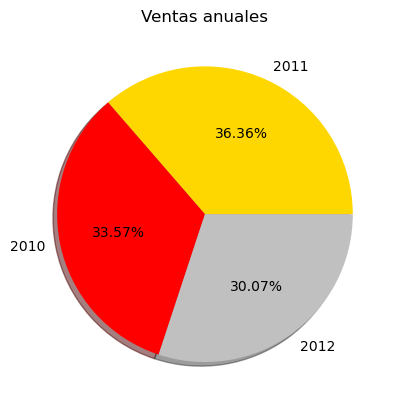

In [15]:
plt.pie(df['Year'].value_counts().values,labels =df['Year'].value_counts().index,
       autopct='%1.2f%%',shadow=True,colors=['gold','red',"silver"])
plt.title('Ventas anuales')
plt.show()

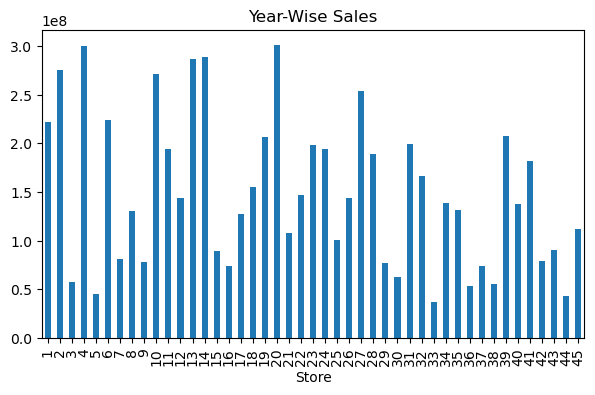

In [16]:
plt.figure(figsize=(7,4))

df.groupby('Store')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Year-Wise Sales')

plt.show()

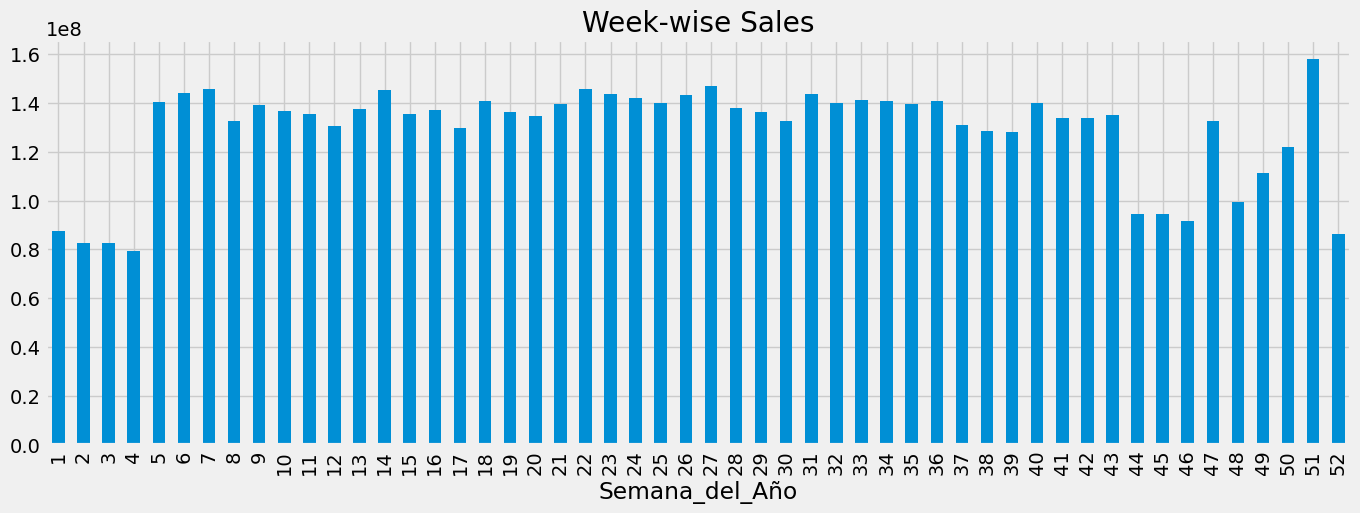

In [49]:
plt.figure(figsize=(15,5))

df.groupby(['Semana_del_Año'])['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Week-wise Sales')

plt.show()

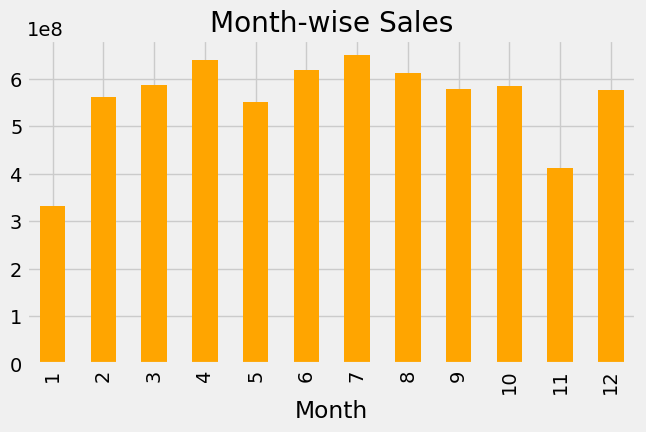

In [50]:
plt.figure(figsize=(7,4))

df.groupby('Month')['Weekly_Sales'].sum().plot(kind='bar',color='Orange')
plt.title('Month-wise Sales')

plt.show()

(-321.70000000000005, 6755.7)

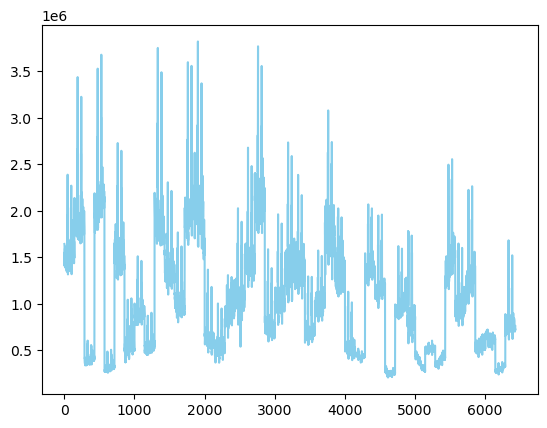

In [18]:
plt.plot(df['Weekly_Sales'], color="skyblue")
plt.xlim()

In [19]:
df['Weekly_Sales'].describe()

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

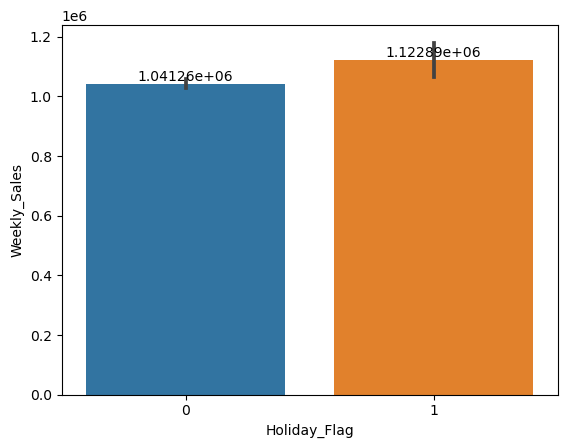

In [20]:
ax = sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
for i in ax.containers:
    ax.bar_label(i,)

In [21]:
lags = 20  # Número de lags
for i in range(1, lags + 1):
    df[f"lag_{i}"] = df["Weekly_Sales"].shift(i)

# Eliminar filas con valores faltantes en las nuevas columnas de lag
df.dropna(subset=[f"lag_{i}" for i in range(1, lags + 1)], inplace=True)

In [22]:
X = df[[f"lag_{i}" for i in range(1, lags + 1)]]
y = df["Weekly_Sales"]
X

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
20,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44,1643690.90
21,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44
22,1492418.14,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17
23,1546074.18,1492418.14,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59
24,1448938.92,1546074.18,1492418.14,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,711671.58,737613.65,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,817741.17,800842.28,770487.37
6431,713173.95,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,711671.58,737613.65,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,817741.17,800842.28
6432,733455.07,713173.95,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,711671.58,737613.65,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,817741.17
6433,734464.36,733455.07,713173.95,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,711671.58,737613.65,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63


In [23]:
Xaux = X[6000:6400]
yaux = y[6000:6400]
Xaux.shape

(400, 20)

In [24]:
plt.rcParams['agg.path.chunksize'] = 200
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=5)  # Puedes ajustar la profundidad máxima según tus necesidades
modelo_arbol.fit(X, y)
predicciones = modelo_arbol.predict(Xaux)

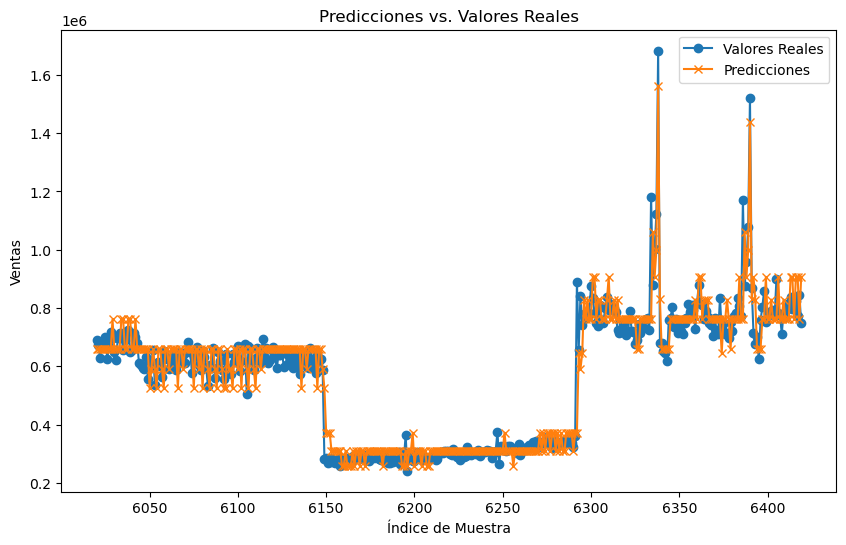

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(yaux.index,yaux, label='Valores Reales', marker='o')
plt.plot(yaux.index,predicciones, label='Predicciones', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')
plt.legend()
plt.show()

In [26]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

dfaux = X.join(y)
dfaux

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,Weekly_Sales
20,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,1466058.28,...,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44,1643690.90,1422711.60
21,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,1391256.12,...,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44,1492418.14
22,1492418.14,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,1425100.71,...,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17,1546074.18
23,1546074.18,1492418.14,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,1603955.12,...,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59,1448938.92
24,1448938.92,1546074.18,1492418.14,1422711.60,1503284.06,1542561.09,1615524.71,1432069.95,1399662.07,1494251.50,...,1425100.71,1391256.12,1466058.28,1545418.53,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68,1385065.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,711671.58,737613.65,...,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,817741.17,800842.28,770487.37,713173.95
6431,713173.95,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,711671.58,...,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,817741.17,800842.28,733455.07
6432,733455.07,713173.95,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,725729.51,...,737613.65,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,817741.17,734464.36
6433,734464.36,733455.07,713173.95,723086.20,702238.27,766512.66,734297.87,718232.26,722496.93,733037.32,...,711671.58,737613.65,749817.08,843361.10,773367.71,822569.16,821498.18,795133.00,837144.63,718125.53


<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

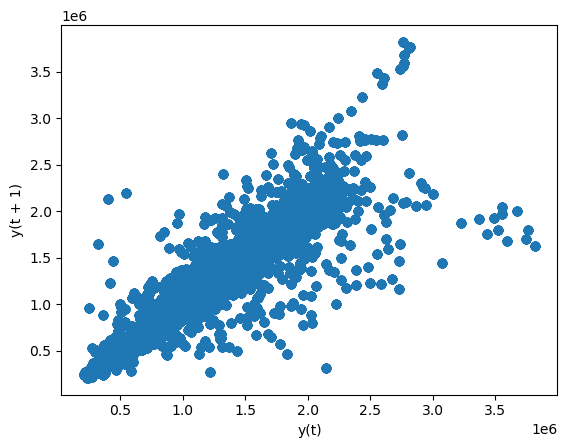

In [27]:
lag_plot(dfaux)

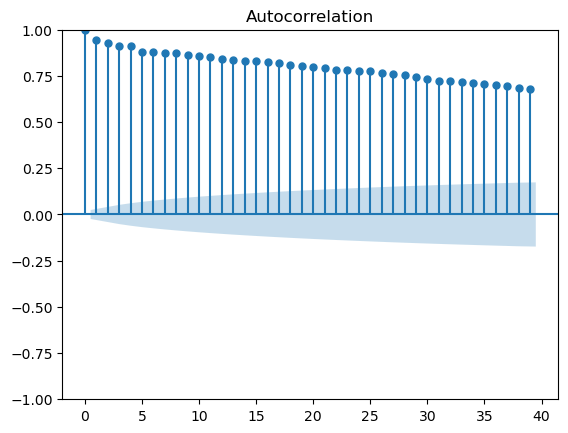

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Weekly_Sales"]);

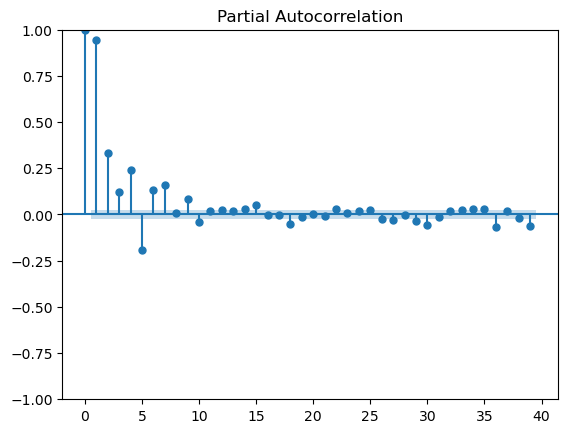

In [29]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df["Weekly_Sales"]);

In [30]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [31]:
df2 = df.rename(columns={'Weekly_Sales': 'y'})

In [39]:
steps = 1000
datos_train = df2[:-steps]
datos_test  = df2[-steps:]

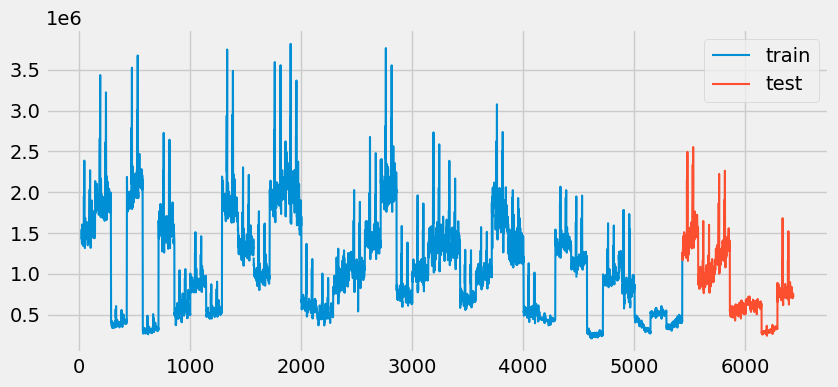

In [40]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

In [41]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 5414] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-02 18:58:31 
Last fit date: 2023-10-02 18:58:37 
Skforecast version: 0.10.1 
Python version: 3.8.18 
Forecaster id: None 

In [42]:
predicciones = forecaster.predict(steps=1000)

In [43]:
pred = pd.DataFrame(predicciones)

In [44]:

pred = pred.set_index(datos_test.index)
pred.head(5)

,pred
5435,1.220154e+06
5436,1.220132e+06
5437,1.104292e+06
5438,1.297211e+06
5439,9.814787e+05


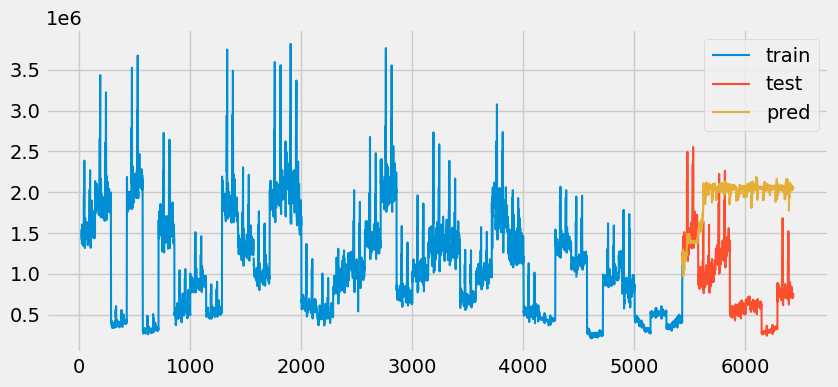

In [45]:
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')

ax.legend();

In [46]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

Error de test (mse) 1495274809824.28


In [64]:
steps = 1000
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [20, 30]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_estimators': [20, 50, 100],
              'max_depth': [ 10 ,20 , 40]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 18.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 1008964020462.3231



In [65]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 20}",1.008964e+12,10,20
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 100}",1.085048e+12,40,100
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 100}",1.086821e+12,20,100
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 50}",1.097015e+12,20,50
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 50}",1.098177e+12,40,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 20}",1.123104e+12,40,20
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",1.127266e+12,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 100}",1.144980e+12,20,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 100}",1.152439e+12,40,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 40, 'n_estimators': 50}",1.160038e+12,40,50


In [66]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=20, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [72]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=1000)

In [73]:
pred = pd.DataFrame(predicciones)
pred = pred.set_index(datos_test.index)
pred.head(5)

,pred
5435,1.213535e+06
5436,1.123709e+06
5437,9.204722e+05
5438,9.165245e+05
5439,8.998020e+05


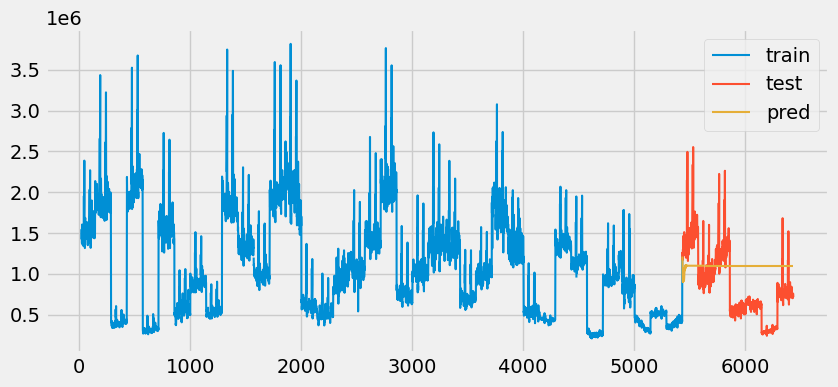

In [74]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
pred.plot(ax=ax, label='predicciones')
ax.legend();

In [78]:
# Backtesting
# ==============================================================================
steps = 1000
n_backtesting = 1000*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df2['y'],
                                    initial_train_size = len(datos_train) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2415
Number of observations used for backtesting: 4000
    Number of folds: 4
    Number of steps per fold: 1000
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   20 -- 2434  (n=2415)
    Validation: 2435 -- 3434  (n=1000)
Fold: 1
    Training:   20 -- 3434  (n=3415)
    Validation: 3435 -- 4434  (n=1000)
Fold: 2
    Training:   20 -- 4434  (n=4415)
    Validation: 4435 -- 5434  (n=1000)
Fold: 3
    Training:   20 -- 5434  (n=5415)
    Validation: 5435 -- 6434  (n=1000)



  0%|          | 0/4 [00:00<?, ?it/s]

Error de backtest: 563522733524.071
